In [1]:
import pandas as pd
from IPython.display import display
import graphviz
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [8]:
def visualize_request_flow(fn, counter):
    df = pd.read_csv(fn)
    if counter > 0:
        df = df[df['counter']==counter]
    # display(df)
    grouped_df = df.groupby(['counter','src_svc', 'dst_svc', 'src_cid', 'dst_cid']).agg({'flow': 'sum', 'total': 'max'}).reset_index()
    grouped_df['weight'] = grouped_df['flow']/grouped_df['total']
    # display(grouped_df)

    node_color_dict = dict()
    node_color_dict["XXXX"] = "gray"
    node_color_dict['-1'] = "#FFBF00"
    node_color_dict['us-west-1'] = "#FFBF00"
    node_color_dict['us-east-1'] = "#ff6375"
    node_color_dict['us-south-1'] = "#bbfbfc"
    node_color_dict['us-central-1'] = "#c8ffbf"

    g_ = graphviz.Digraph()
    # plot_dict_wo_compute_edge(network_arc, g_)
    node_pw = "1"
    edge_pw = "0.5"
    fs = "8"
    edge_fs = "10"
    fn="times bold italic"
    edge_arrowsize="0.5"
    edge_minlen="1"
    cluster_list = list()
    
    '''
    frontend,slateingress@GET@/hotels,frontend@GET@/hotels
    slateingress,frontend,slateingress@POST@/user,frontend@POST@/user
    slateingress,frontend,slateingress@GET@/recommendations
    slateingress,frontend,slateingress@POST@/reservation
    '''
    edge_color_dict = dict()
    edge_color_dict["frontend@GET@/hotels"] = "blue" # search
    edge_color_dict["frontend@POST@/user"] = "green" # user
    edge_color_dict["frontend@GET@/recommendations"] = "orange" # recommendataion
    edge_color_dict["frontend@POST@/reservation"] = "red" # reserve
    edge_color_dict["slateingress@GET@/hotels"] = "blue" # search
    edge_color_dict["slateingress@POST@/user"] = "green" # user
    edge_color_dict["slateingress@GET@/recommendations"] = "orange" # recommendataion
    edge_color_dict["slateingress@POST@/reservation"] = "red" # reserve
    
    # df = df.drop_duplicates(subset=["src_svc", "dst_svc", "src_cid", "dst_cid", "src_endpoint", "dst_endpoint", "flow", "total", "weight"], keep='last')
    df = df.drop_duplicates(subset=["src_svc", "dst_svc", "src_cid", "dst_cid", "flow", "total", "weight"], keep='last')
    for index, row in df.iterrows():
        # if row["flow"] <= 0 or row["weight"] <= 0:
        src_cid = row["src_cid"]
        dst_cid = row["dst_cid"]
        src_svc = row["src_svc"].split("-")[-1]
        dst_svc = row["dst_svc"].split("-")[-1]
        src_endpoint = row["src_endpoint"]
        dst_endpoint = row["dst_endpoint"]
        cluster_list.append(src_cid)
        if src_svc == "SOURCE":
            edge_style = 'filled'
        elif src_cid == dst_cid:
            edge_style = 'filled'
        else:
            edge_style = 'dashed'
        ##############################################
        if (src_svc == "SOURCE" and dst_endpoint in edge_color_dict) or (src_svc == "slateingress" and dst_endpoint in edge_color_dict):
            edge_color = edge_color_dict[dst_endpoint]
        else:
            if src_cid != dst_cid:
                edge_color = 'purple'
            else:
                edge_color = 'black'
        try:
            src_node_color = node_color_dict[src_cid]
            dst_node_color = node_color_dict[dst_cid]
            src_node_name = src_svc+str(src_cid)
            dst_node_name = dst_svc+str(dst_cid)
            src_node_label = src_svc+"\n"+str(src_cid)
            dst_node_label = dst_svc+"\n"+str(dst_cid)
            g_.node(name=src_node_name, label=src_node_label, shape='circle', style='filled', fillcolor=src_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=dst_node_name, label=dst_node_label, shape='circle', style='filled', fillcolor=dst_node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            if src_svc == "SOURCE":
                edge_label = f'{round(row["flow"],1)}'
            elif int(row["flow"]) > 0:
                edge_label = f'{round(row["flow"],1)}({int(round(row["weight"], 2)*100)}%)'
            else:
                edge_label = f'({int(round(row["weight"], 2)*100)}%)'
            g_.edge(src_node_name, dst_node_name, label=edge_label, penwidth=edge_pw, style=edge_style, fontsize=edge_fs, fontcolor=edge_color, color=edge_color, arrowsize=edge_arrowsize, minlen=edge_minlen)
        except Exception as e:
            print(f"Error: {e}")
            print(f"Error row: {row}")
        
    # Adding a legend
    with g_.subgraph(name='cluster_legend') as c:
        c.attr(label='Legend')
        legend_fontsize='10'
        for cluster in cluster_list:
            if cluster == "XXXX":
                continue
            c.node(cluster, label=cluster.split('-')[1], shape='circle', style='filled', fillcolor=node_color_dict[cluster], fontsize=legend_fontsize, fixedsize='true', width='0.3', height='0.3')
        legend_counter = 0
        for ed in edge_color_dict:
            src = f'legend_src_{legend_counter}'
            dst = f'legend_dst_{legend_counter}'
            c.node(src, label='', style='invisible')  # Creating an invisible source node
            c.node(dst, label='', style='invisible')  # Creating an invisible destination node
            c.edge(src, dst, label=ed.split('@')[-1], color=edge_color_dict[ed], fontsize=legend_fontsize)  # Connecting the nodes
            legend_counter += 1

    return g_


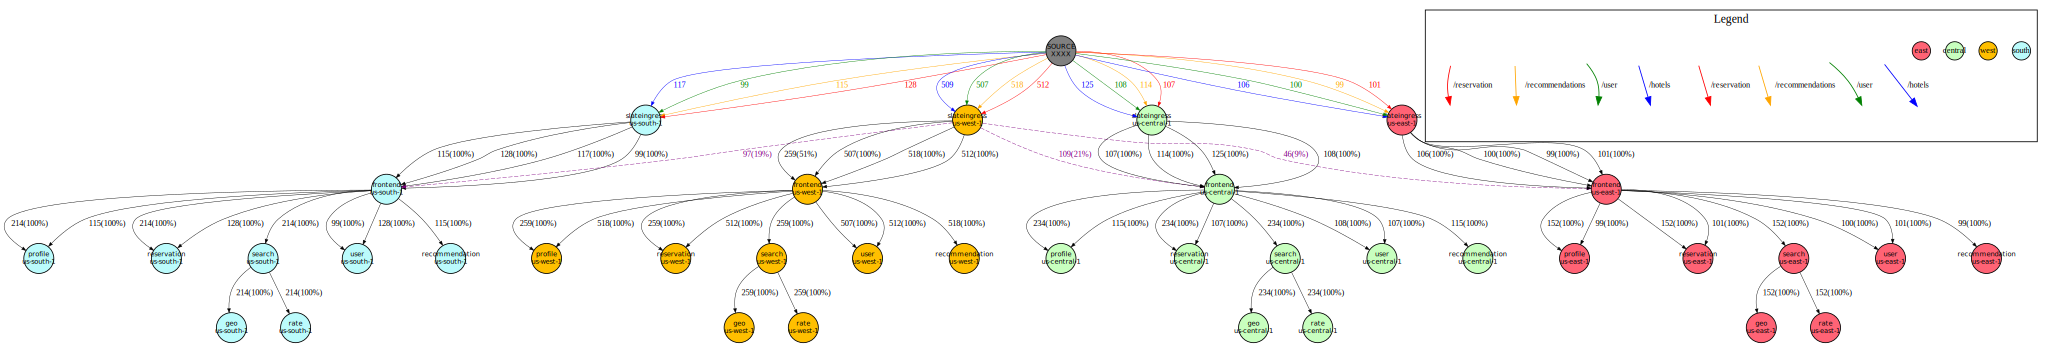

In [9]:
fn = 'test.csv'
counter = -1
g_ = visualize_request_flow(fn, counter)
# g_.render('/users/gangmuk/projects/slate-benchmark/metrics-microservice-app/runtime-test/w300c50s300e50/graphviz')
g_

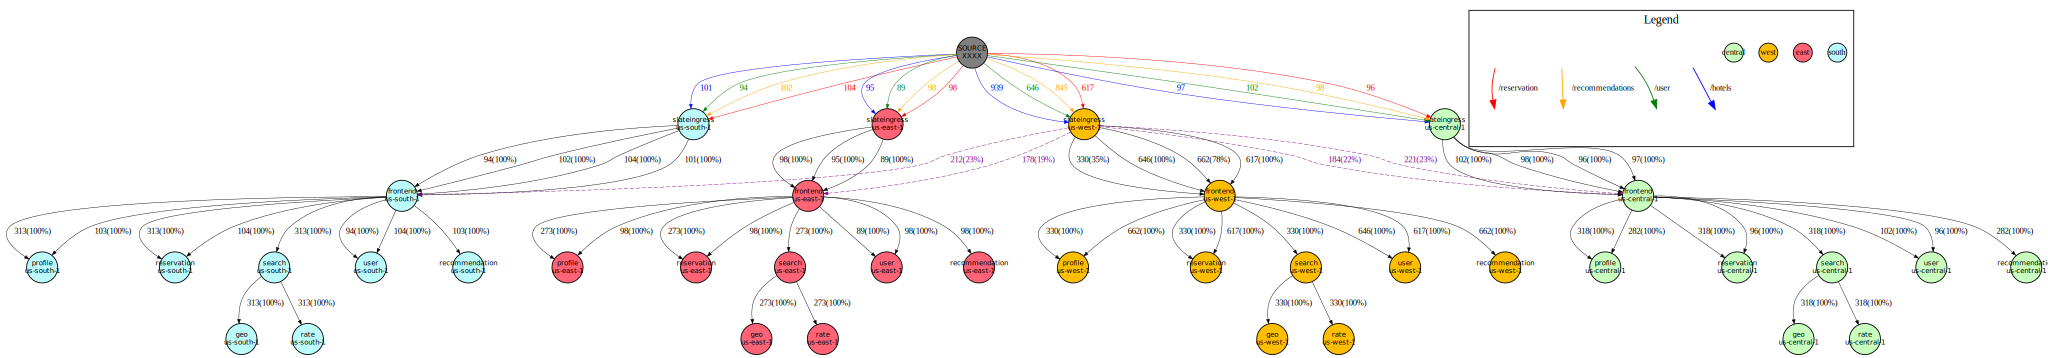

In [129]:
fn = 'test2.csv'
counter = -1
g_ = visualize_request_flow(fn, counter)
# g_.render('/users/gangmuk/projects/slate-benchmark/metrics-microservice-app/runtime-test/w300c50s300e50/graphviz')
g_